<a href="https://colab.research.google.com/github/mavillan/gb-vpp/blob/main/models/gb-vpp-lstm-pl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
!pip uninstall -y tensorflow 
!pip install tensorflow==2.4.3 > /dev/null 2>&1

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
Tensorflow version 2.4.3
Running on TPU  ['10.60.165.122:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.60.165.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.165.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
!mkdir -p input/
!kaggle competitions download -c ventilator-pressure-prediction -p input/ --force

!unzip -o input/sample_submission.csv.zip -d input/
!unzip -o input/train.csv.zip -d input/
!unzip -o input/test.csv.zip -d input/

 78% 59.0M/75.4M [00:00<00:00, 71.6MB/s]
100% 75.4M/75.4M [00:00<00:00, 103MB/s] 
100% 8.50M/8.50M [00:00<00:00, 88.9MB/s]

 90% 125M/139M [00:01<00:00, 112MB/s] 
100% 139M/139M [00:01<00:00, 125MB/s]
Archive:  input/sample_submission.csv.zip
  inflating: input/sample_submission.csv  
Archive:  input/train.csv.zip
  inflating: input/train.csv         
Archive:  input/test.csv.zip
  inflating: input/test.csv          


In [4]:
!mkdir -p subs/
!kaggle datasets download -d mavillan/gb-vpp-subs -p subs --force --unzip

 75% 20.0M/26.6M [00:00<00:00, 46.3MB/s]
100% 26.6M/26.6M [00:00<00:00, 67.2MB/s]


In [5]:
input_path = "input"
subs_path = "/content/drive/MyDrive/kaggle/gb-vpp/subs"
results_path = "/content/drive/MyDrive/kaggle/gb-vpp/results"
artifacts_path = "/content/drive/MyDrive/kaggle/gb-vpp/artifacts"

***

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

***
## data preparation

In [7]:
SEQ_LEN = 80

In [8]:
train_raw = pd.read_csv(f'{input_path}/train.csv')
test_raw = pd.read_csv(f'{input_path}/test.csv')
submission = pd.read_csv(f'{input_path}/sample_submission.csv')

pseudo_labels = pd.read_csv("subs/public_0.164.csv")

In [9]:
mapping = {j:i for i,j in enumerate(train_raw.breath_id.unique())}
train_raw["breath_id"] = train_raw.breath_id.map(mapping)

if SEQ_LEN < 80:

    train_raw = (
        train_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )
    test_raw = (
        test_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )

In [10]:
def compute_feats(dataframe):
    dataframe = dataframe.copy()

    # time features
    dataframe["time_diff"] = dataframe.groupby("breath_id")["time_step"].diff()
    dataframe['time_since_expiratory']= dataframe['time_step'] * dataframe['u_out']

    # lag features
    lags = [1,2]
    for lag in lags:
        dataframe[f"u_in_lag{lag}"] = dataframe.groupby("breath_id")["u_in"].shift(lag).fillna(0)

    # stats on u_in
    dataframe["u_in_cumsum"] = dataframe.groupby("breath_id")["u_in"].cumsum()
    dataframe['u_in_cummean'] =dataframe['u_in_cumsum'] / (dataframe.groupby("breath_id")["id"].cumcount()+1)
    #dataframe['u_in_last'] = dataframe.groupby('breath_id')['u_in'].transform('last')
    dataframe['cross1']= dataframe['u_in'] * dataframe['u_out']
    dataframe['cross2']= dataframe['u_in'] * (1 - dataframe['u_out'])

    dataframe['area'] = dataframe['time_step'] * dataframe['u_in']
    dataframe['area'] = dataframe.groupby('breath_id')['area'].cumsum()
    
    dataframe['vol_diff'] = (dataframe['time_diff']*dataframe['u_in']).fillna(0)
    dataframe['vol_diff_cumsum'] = dataframe.groupby('breath_id')['vol_diff'].cumsum()

    # gradients of u_in
    def compute_grad_1st(df):
        return np.gradient(df.u_in, 100*df.time_step)
    def compute_grad_2nd(df):
        return np.gradient(df.grad_1st, 100*df.time_step)

    gb_result = dataframe.groupby("breath_id").apply(compute_grad_1st)
    dataframe["grad_1st"] = np.concatenate(gb_result.values)
    gb_result = dataframe.groupby("breath_id").apply(compute_grad_2nd)
    dataframe["grad_2nd"] = np.concatenate(gb_result.values)

    # nan filling
    dataframe["time_diff"] = dataframe["time_diff"].fillna(method="bfill")
    
    # ohe of R&C values    
    dataframe['R'] = dataframe['R'].astype(str)
    dataframe['C'] = dataframe['C'].astype(str)
    dataframe['RC'] = dataframe['R']+dataframe['C']
    dataframe = pd.get_dummies(dataframe)
    return dataframe

train = compute_feats(train_raw)
test  = compute_feats(test_raw)


In [11]:
train_targets = train[['pressure']].to_numpy().reshape(-1, SEQ_LEN)

test = pd.merge(test, pseudo_labels, how="inner", on="id")
test_targets = test[['pressure']].to_numpy().reshape(-1, SEQ_LEN)

cols_to_exclude_train = exclude = ["id","breath_id","pressure"]
cols_to_exclude_test = exclude = ["id","breath_id","pressure"]

train.drop(cols_to_exclude_train, axis=1, inplace=True)
test.drop(cols_to_exclude_test, axis=1, inplace=True)

In [12]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [13]:
train = train.reshape(-1, SEQ_LEN, train.shape[-1])
test = test.reshape(-1, SEQ_LEN, train.shape[-1])

***
## model training

In [15]:
def build_model(input_dim):
    with tpu_strategy.scope():   
        inputs = layers.Input(shape = input_dim)
        
        h1 = layers.Bidirectional(layers.LSTM(300, return_sequences=True))(inputs)
        h2 = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(h1)
        h3 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(h2)
        h4 = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(h3) 
                
        hcat = layers.Concatenate()([h2,h3,h4])
        hcat = layers.Dropout(0.1)(hcat)
        out = layers.Dense(64, activation = 'swish')(hcat)
        out = layers.Dense(1)(out)
        
        model = keras.Model(inputs, out)
        model.compile(optimizer="adam", loss="mae")
           
    return model  

----------------------------------- Fold: 1 ------------------------------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 31)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 80, 600)      796800      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80, 512)      1755136     bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 80, 256)      656384      bidirectional_1[0][0]            
_____________

None

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
217/217 [==============================] - 47s 129ms/step - loss: 2.4114 - val_loss: 0.6381
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009996746, shape=(), dtype=float32).
217/217 [==============================] - 12s 57ms/step - loss: 0.5942 - val_loss: 0.5643
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009993492, shape=(), dtype=float32).
217/217 [==============================] - 12s 57ms/step - loss: 0.4940 - val_loss: 0.4734
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(), dtype=float32).
217/217 [==============================] - 12s 57ms/step - loss: 0.4483 - val_loss: 0.4890
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009986989, shape=(), dtype=float32).
217/217 [=============

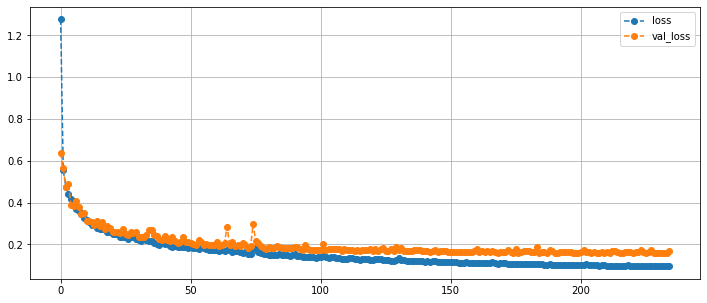

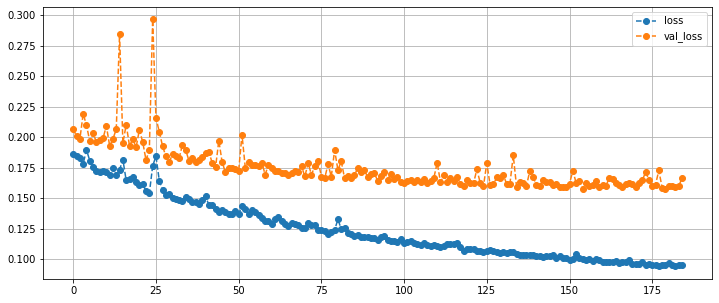

----------------------------------- Fold: 2 ------------------------------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 31)]     0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 80, 600)      796800      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 80, 512)      1755136     bidirectional_4[0][0]            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 80, 256)      656384      bidirectional_5[0][0]            
___________

None

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
217/217 [==============================] - 47s 130ms/step - loss: 2.4710 - val_loss: 0.6111
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009996746, shape=(), dtype=float32).
217/217 [==============================] - 13s 58ms/step - loss: 0.5945 - val_loss: 0.5279
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009993492, shape=(), dtype=float32).
217/217 [==============================] - 13s 58ms/step - loss: 0.4934 - val_loss: 0.4449
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(), dtype=float32).
217/217 [==============================] - 13s 58ms/step - loss: 0.4526 - val_loss: 0.4713
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009986989, shape=(), dtype=float32).
217/217 [=============

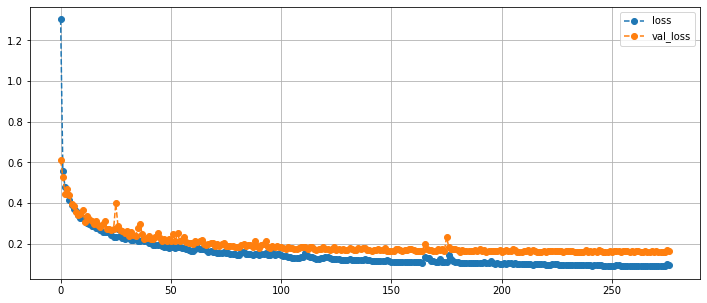

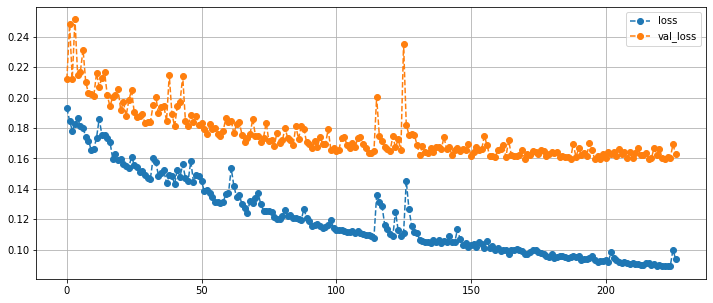

----------------------------------- Fold: 3 ------------------------------------
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80, 31)]     0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 80, 600)      796800      input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 80, 512)      1755136     bidirectional_8[0][0]            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 80, 256)      656384      bidirectional_9[0][0]            
___________

None

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
217/217 [==============================] - 48s 129ms/step - loss: 2.4845 - val_loss: 0.6464
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009996746, shape=(), dtype=float32).
217/217 [==============================] - 12s 57ms/step - loss: 0.6009 - val_loss: 0.4891
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009993492, shape=(), dtype=float32).
217/217 [==============================] - 12s 58ms/step - loss: 0.4965 - val_loss: 0.4768
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(), dtype=float32).
217/217 [==============================] - 12s 58ms/step - loss: 0.4535 - val_loss: 0.4201
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009986989, shape=(), dtype=float32).
217/217 [=============

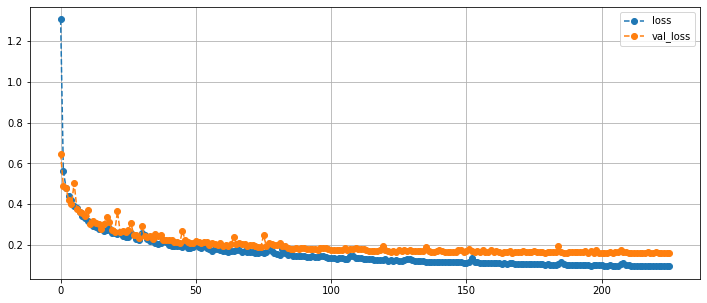

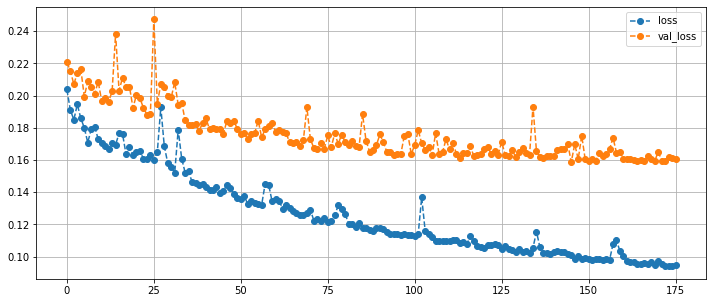

----------------------------------- Fold: 4 ------------------------------------
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 80, 31)]     0                                            
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 80, 600)      796800      input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, 80, 512)      1755136     bidirectional_12[0][0]           
__________________________________________________________________________________________________
bidirectional_14 (Bidirectional (None, 80, 256)      656384      bidirectional_13[0][0]           
___________

None

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
217/217 [==============================] - 48s 130ms/step - loss: 2.3983 - val_loss: 0.5993
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009996746, shape=(), dtype=float32).
217/217 [==============================] - 13s 58ms/step - loss: 0.5827 - val_loss: 0.4867
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009993492, shape=(), dtype=float32).
217/217 [==============================] - 13s 58ms/step - loss: 0.4889 - val_loss: 0.4467
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(), dtype=float32).
217/217 [==============================] - 13s 58ms/step - loss: 0.4494 - val_loss: 0.4273
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009986989, shape=(), dtype=float32).
217/217 [=============

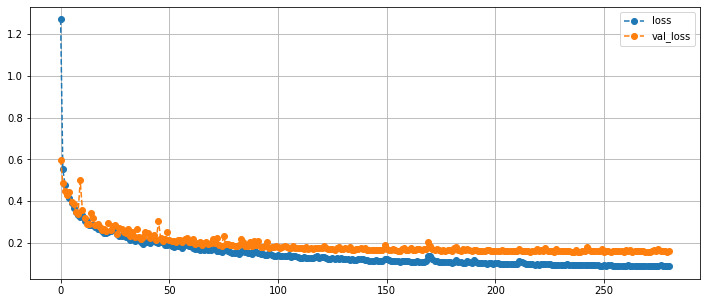

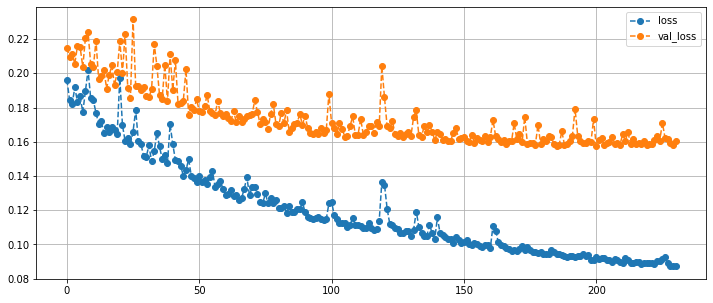

----------------------------------- Fold: 5 ------------------------------------
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 80, 31)]     0                                            
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 80, 600)      796800      input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, 80, 512)      1755136     bidirectional_16[0][0]           
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 80, 256)      656384      bidirectional_17[0][0]           
___________

None

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
217/217 [==============================] - 49s 130ms/step - loss: 2.4136 - val_loss: 0.6496
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009996746, shape=(), dtype=float32).
217/217 [==============================] - 12s 57ms/step - loss: 0.5879 - val_loss: 0.5466
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009993492, shape=(), dtype=float32).
217/217 [==============================] - 12s 57ms/step - loss: 0.5054 - val_loss: 0.4511
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(), dtype=float32).
217/217 [==============================] - 13s 58ms/step - loss: 0.4533 - val_loss: 0.4370
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009986989, shape=(), dtype=float32).
217/217 [=============

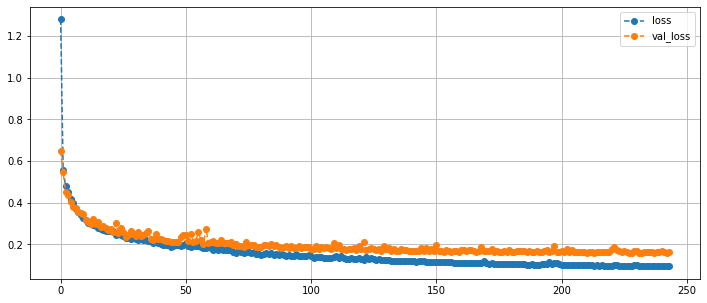

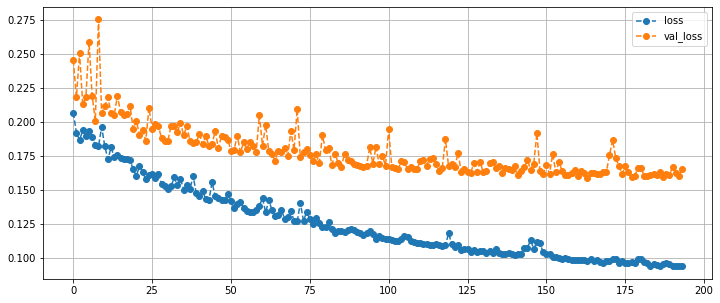

In [16]:
EPOCH = 300
BATCH_SIZE = 512

kf = KFold(n_splits=5, shuffle=True, random_state=2021)
models_by_fold = list()

oof = train_raw[["id","breath_id","u_out","pressure"]].copy()

for fold, (train_idx,valid_idx) in enumerate(kf.split(train)):

    print(f" Fold: {fold+1} ".center(80, "-"))
    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = train_targets[train_idx], train_targets[valid_idx]

    # PL augmentation
    X_train = np.concatenate([X_train, test], axis=0)
    y_train = np.concatenate([y_train, test_targets], axis=0)

    model = build_model(input_dim=train.shape[-2:])
    display(model.summary())

    scheduler = ExponentialDecay(
        initial_learning_rate=1e-3, 
        decay_steps=EPOCH*((len(train)*0.8)/BATCH_SIZE), 
        decay_rate=1e-5
    )
    lr = LearningRateScheduler(scheduler, verbose=1)
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=30, 
        verbose=1,
        restore_best_weights=True,
    )
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=EPOCH, 
        batch_size=BATCH_SIZE, 
        callbacks=[lr,es],
        verbose=1,
    )
    models_by_fold.append(model)

    # generate the oof predictions
    x_valid_tf = tf.convert_to_tensor(X_valid, dtype=tf.float32)
    oof_preds = model.call(x_valid_tf, training=False).numpy().squeeze()
    idx = oof.query("breath_id in @valid_idx").index
    oof.loc[idx, "pred"] = oof_preds.ravel()

    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"], "o--", label="loss")
    plt.plot(history.history["val_loss"], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"][50:], "o--", label="loss")
    plt.plot(history.history["val_loss"][50:], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

In [17]:
print("mae:", oof.eval("abs(pressure - pred)").mean())
print("mae inspiratory:", oof.query("u_out == 0").eval("abs(pressure - pred)").mean())
print("mae expiratory :", oof.query("u_out == 1").eval("abs(pressure - pred)").mean())

mae: 0.15838549821684894
mae inspiratory: 0.17731654175485345
mae expiratory : 0.14680471200411457


lstm_v5
- mae: 0.19870362716674497
- mae inspiratory: 0.24693164942887788
- mae expiratory : 0.169200847028661

lstm_v4
- mae: 0.19910630745529212
- mae inspiratory: 0.24139623415898287
- mae expiratory : 0.1732360695506279

lstm_v3
- mae: 0.1894350191416654
- mae inspiratory: 0.22527142074094628
- mae expiratory : 0.16751262988059495

lstm_v2
- mae: 0.20938487189579605
- mae inspiratory: 0.2124941942660988
- mae expiratory : 0.19958701148249222

lstm_v1
- mae: 0.18086928169783648
- mae inpiratory: 0.2031012730817264
- mae expiratory: 0.16726918940573152

***
## sub generation

In [18]:
all_preds = list()
test_tf = tf.convert_to_tensor(test, dtype=tf.float32)

for model in models_by_fold:
    preds = model.call(test_tf, training=False).numpy().squeeze().ravel()
    all_preds.append(preds)

test_raw["pressure"] = np.mean(all_preds, axis=0)

In [19]:
sub = pd.merge(submission["id"], test_raw[["id","pressure"]], how="left", on="id")
sub["pressure"] = sub["pressure"].fillna(0)
sub.to_csv(f"{subs_path}/sub_lstm.csv", index=False)

In [20]:
oof.to_csv(f"{results_path}/oof_lstm.csv", index=False)

***